In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from math import ceil

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.7.0-rc1'

In [3]:
def data_generator(X, y, batch_size = 32, epochs = 1, shuffle = True):
    from collections import namedtuple
    from math import ceil
    Batch = namedtuple("batch", ["epoch", "global_step", "progress", "X_batch", "y_batch"])
    global_step = 0
    for epoch in range(epochs):
        m = X.shape[0]
        if shuffle: 
            indices = np.arange(m)
            np.random.shuffle(indices)
            X = X[indices]
            y = None if y is None else y[indices]
        num_batches = ceil(m/batch_size)
        for j in range(num_batches):
            start = j * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = None if y is None else y[start:end]
            progress = int((j + 1) * 100 / num_batches)
            yield Batch(epoch, global_step, progress, X_batch, y_batch)
            global_step = global_step + 1

In [4]:
import os, pickle
import pickle

def cifar10(data_path):

    def _load_data_(files):
        X = np.empty([0, 3072])
        y = np.empty([0])
        for path in files:
            print(path)
            with open(path, "rb") as f:
                d = pickle.load(f, encoding='bytes')
                X = np.vstack([X, d[b"data"]]).astype("uint8")
                y = np.hstack([y, d[b"labels"]]).astype("uint8")
        return X, y
    
    training_files = [os.path.join(data_path, "data_batch_{0}".format(i))  for i in range(1, 6)]
    test_files = [os.path.join(data_path, "test_batch")]
    labels_file = os.path.join(data_path, "batches.meta")

    X_train, y_train = _load_data_(training_files)
    X_test, y_test = _load_data_(test_files)

    X_train = X_train.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255
    X_test = X_test.reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1])/255

    with open(labels_file, "rb") as f:
        labels = pickle.load(f, encoding="bytes")
    labels = [s.decode("utf-8")  for s in labels[b'label_names']]
    return X_train, X_test, y_train, y_test, labels

X_train, X_test, y_train, y_test, labels = cifar10("/data/cifar-10-batches-py/")
print("X_train:", X_train.shape, 
      "\nX_test:", X_test.shape, 
      "\ny_train: ", y_train.shape, 
      "\ny_test:", y_test.shape, 
      "\nlabels: ", labels)

/data/cifar-10-batches-py/data_batch_1
/data/cifar-10-batches-py/data_batch_2
/data/cifar-10-batches-py/data_batch_3
/data/cifar-10-batches-py/data_batch_4
/data/cifar-10-batches-py/data_batch_5
/data/cifar-10-batches-py/test_batch
X_train: (50000, 32, 32, 3) 
X_test: (10000, 32, 32, 3) 
y_train:  (50000,) 
y_test: (10000,) 
labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
eye = np.eye(len(labels))
Y_train = eye[y_train]
Y_test = eye[y_test]
Y_train.shape, Y_test.shape

((50000, 10), (10000, 10))

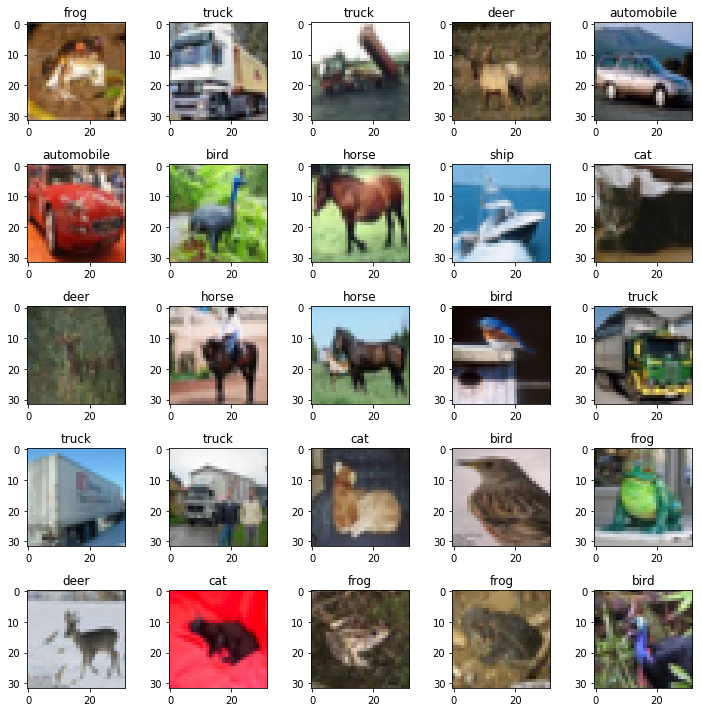

In [6]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_train[i])
    label = labels[y_train[i]]
    ax.set_title(label)
    
plt.tight_layout()

Let's take a look at differente horse images

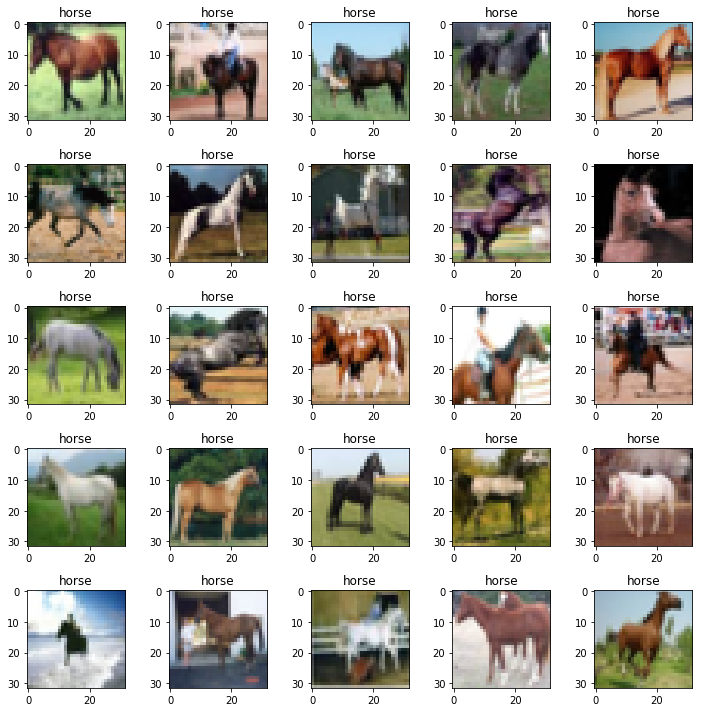

In [7]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    data_filter = y_train == 7
    ax.imshow(X_train[data_filter][i])
    label = labels[y_train[data_filter][i]]
    ax.set_title(label)
    
plt.tight_layout()

Display some images from test dataset

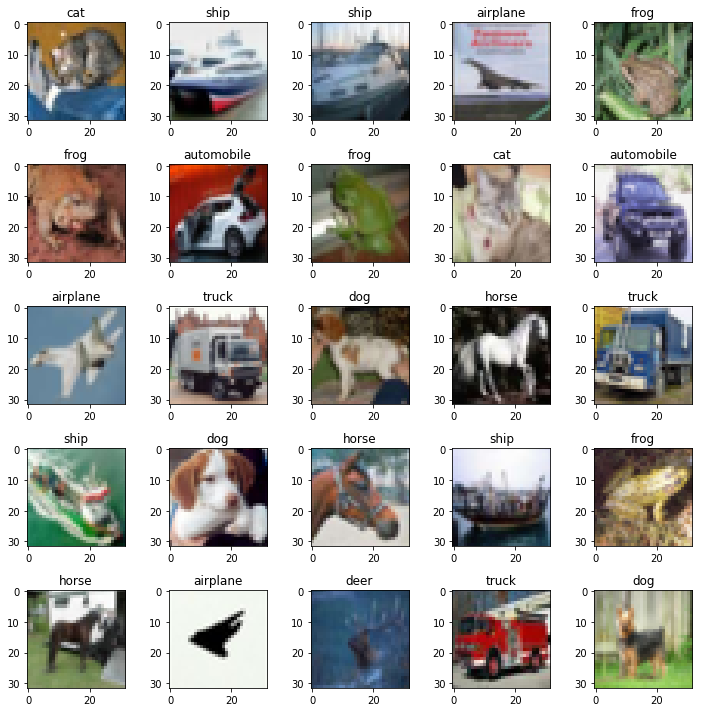

In [8]:
fig, _ = plt.subplots(5, 5, figsize= (10, 10))

for i, ax in enumerate(fig.axes):
    ax.imshow(X_test[i])
    label = labels[y_test[i]]
    ax.set_title(label)
    
plt.tight_layout()

Build a simple fully connected network with no hiddent layer.

In [9]:
tf.set_random_seed(1)
tf.reset_default_graph()

learning_rate = 0.001

X = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 3))
Y = tf.placeholder(dtype=tf.int32, shape=(None, 10))

X_flat = tf.reshape(X, (-1, 32 * 32 * 3))

logits = tf.layers.dense(X_flat, 10, activation=None, name="dense1")
Y_probs = tf.nn.softmax(logits)
loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

match = tf.equal(tf.argmax(Y, axis=1), tf.argmax(logits, axis = 1))
accuracy = tf.reduce_mean(tf.cast(match, tf.float32))

weights = [gv for gv in tf.global_variables() if "kernel" in gv.name][0]
weights = tf.transpose(weights)

y_pred = tf.argmax(logits, axis=1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for batch in data_generator(X_train, Y_train, batch_size=64, epochs=50):
        _, cost_, accuracy_, weights_, logits_ = sess.run([opt, cost, accuracy, weights, logits]
                                , feed_dict = {X: batch.X_batch, Y: batch.y_batch})
        print("Epoch: %d, progress: %f, cost: %f, acc: %f" 
                % (batch.epoch, batch.progress, cost_, accuracy_), end="\r")
        if batch.progress == 100:
            y_test_pred = np.array([], dtype=np.int32)
            for test_batch in data_generator(X_test, Y_test, shuffle=False):
                y_test_pred = np.concatenate([y_test_pred, sess.run(y_pred, feed_dict={X: test_batch.X_batch})])
            print("\nTest accuracy: ", np.mean(y_test_pred == y_test))

Epoch: 0, progress: 100.000000, cost: 1.860186, acc: 0.312500
Test accuracy:  0.2587
Epoch: 1, progress: 100.000000, cost: 2.107845, acc: 0.312500
Test accuracy:  0.3121
Epoch: 2, progress: 100.000000, cost: 1.671071, acc: 0.437500
Test accuracy:  0.3169
Epoch: 3, progress: 100.000000, cost: 1.852216, acc: 0.250000
Test accuracy:  0.3391
Epoch: 4, progress: 100.000000, cost: 1.762622, acc: 0.250000
Test accuracy:  0.3409
Epoch: 5, progress: 100.000000, cost: 1.818830, acc: 0.500000
Test accuracy:  0.3423
Epoch: 6, progress: 100.000000, cost: 1.918348, acc: 0.312500
Test accuracy:  0.3581
Epoch: 7, progress: 100.000000, cost: 1.709270, acc: 0.562500
Test accuracy:  0.3588
Epoch: 8, progress: 100.000000, cost: 1.738122, acc: 0.375000
Test accuracy:  0.3638
Epoch: 9, progress: 100.000000, cost: 1.783221, acc: 0.312500
Test accuracy:  0.3644
Epoch: 10, progress: 100.000000, cost: 1.967965, acc: 0.187500
Test accuracy:  0.3639
Epoch: 11, progress: 100.000000, cost: 1.925542, acc: 0.375000
T

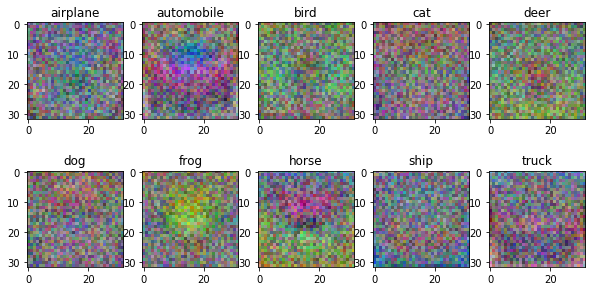

In [10]:
weights_ = (weights_ - np.min(weights_)) / (np.max(weights_) - np.min(weights_))
np.max(weights_), np.min(weights_)
fig, _ = plt.subplots(2, 5, figsize = (10, 5))
for i, ax in enumerate(fig.axes):
    ax.imshow(weights_[i].reshape(32, 32, 3))
    ax.set_title(labels[i])

In [12]:
tf.set_random_seed(1)
tf.reset_default_graph()

learning_rate = 0.001

X = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 3))
Y = tf.placeholder(dtype=tf.int32, shape=(None, 10))
dropout_rate = tf.placeholder_with_default(0.0, shape=())

conv1 = tf.layers.conv2d(X, activation=tf.nn.relu, filters=32, kernel_size=(5, 5))
pool1 = tf.layers.max_pooling2d(conv1, pool_size=(2, 2), strides=(2, 2))
conv2 = tf.layers.conv2d(pool1, activation=tf.nn.relu, filters=64, kernel_size=(3, 3))
pool2 = tf.layers.max_pooling2d(conv2, pool_size=(2, 2), strides=(2, 2))
flat1 = tf.layers.flatten(pool2)
dropout1 = tf.layers.dropout(flat1, rate=dropout_rate)
fc1 = tf.layers.dense(dropout1, 800, activation=tf.nn.relu)
fc2 = tf.layers.dense(fc1, 100, activation=tf.nn.relu)
logits = tf.layers.dense(fc2, 10, activation=None)

loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

match = tf.equal(tf.argmax(Y, axis=1), tf.argmax(logits, axis = 1))
accuracy = tf.reduce_mean(tf.cast(match, tf.float32))

weights = [gv for gv in tf.global_variables() if "kernel" in gv.name][0]
weights = tf.transpose(weights)

y_pred = tf.argmax(logits, axis=1)
Y_probs = tf.nn.softmax(logits)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for batch in data_generator(X_train, Y_train, batch_size=64, epochs=50):
        _, cost_, accuracy_, weights_, logits_ = sess.run([opt, cost, accuracy, weights, logits]
                                , feed_dict = {X: batch.X_batch, Y: batch.y_batch, dropout_rate: 0.8})
        print("Epoch: %d, progress: %f, cost: %f, acc: %f" 
                % (batch.epoch, batch.progress, cost_, accuracy_), end="\r")
        if batch.progress == 100:
            y_test_pred = np.array([], dtype=np.int32)
            for test_batch in data_generator(X_test, Y_test, shuffle= False):
                y_test_pred = np.concatenate([y_test_pred, sess.run(y_pred, feed_dict={X: test_batch.X_batch})])
            print("\nTest accuracy: ", np.mean(y_test_pred == y_test))

Epoch: 0, progress: 100.000000, cost: 1.284849, acc: 0.562500
Test accuracy:  0.5624
Epoch: 1, progress: 100.000000, cost: 0.952502, acc: 0.687500
Test accuracy:  0.6574
Epoch: 2, progress: 100.000000, cost: 0.576836, acc: 0.750000
Test accuracy:  0.672
Epoch: 3, progress: 100.000000, cost: 0.807215, acc: 0.750000
Test accuracy:  0.6968
Epoch: 4, progress: 100.000000, cost: 0.541717, acc: 0.750000
Test accuracy:  0.6998
Epoch: 5, progress: 100.000000, cost: 0.344130, acc: 0.812500
Test accuracy:  0.6962
Epoch: 6, progress: 100.000000, cost: 0.352250, acc: 0.812500
Test accuracy:  0.7006
Epoch: 7, progress: 100.000000, cost: 0.047712, acc: 1.000000
Test accuracy:  0.7024
Epoch: 8, progress: 100.000000, cost: 0.231757, acc: 0.937500
Test accuracy:  0.6952
Epoch: 9, progress: 100.000000, cost: 0.013128, acc: 1.000000
Test accuracy:  0.689
Epoch: 10, progress: 100.000000, cost: 0.084196, acc: 1.000000
Test accuracy:  0.6929
Epoch: 11, progress: 100.000000, cost: 0.039516, acc: 1.000000
Tes

In [17]:
n_x = 32 * 32 * 3
n_y = 10
n_H, n_W, n_C = 32, 32, 3 
n_h = 400
epochs = 10
batch_size = 16
batch_count = ceil(X_train.shape[0]/batch_size)

tf.reset_default_graph()
tf.set_random_seed(1)

learning_rate = 0.001

X =tf.placeholder(dtype=tf.float32, shape = [None, n_H, n_W, n_C])
y =tf.placeholder(dtype=tf.int32, shape = [None])
keep_prob = tf.placeholder_with_default(1.0, shape = [])

y_oh =tf.one_hot(indices = y, depth = n_y)

def full_layer(name, input, size, activation = None):
    input_size = int(input.get_shape()[1])
    W = tf.get_variable(name=name + "_W", shape=[input_size, size], 
                initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([size]))
    Z = tf.matmul(input, W) + b
    
    if not activation is None:
        Z = activation(Z)
    
    Z = tf.nn.dropout(Z, keep_prob = keep_prob)
    
    return Z

def conv_layer(name, input, shape, strides, padding = "VALID"):
    W = tf.get_variable(name + "_W", shape = shape, 
                        initializer=tf.contrib.layers.xavier_initializer())
    b = tf.Variable(tf.zeros([shape[3]]))
    
    A = tf.nn.conv2d(input, W, strides, padding)
    A = tf.nn.relu(A + b)
    
    return A

def pooling_layer(input, ksize, strides, padding = "VALID"):
    A = tf.nn.max_pool(value = input, ksize = ksize, strides = strides, padding = padding)
    return A
    

conv1 = conv_layer("c1", X, shape =  [5, 5, 3, 32], strides = [1, 1, 1, 1])
print("conv1", conv1)
pool1 = pooling_layer(conv1,ksize=[1, 2, 2, 1],strides= [1, 2, 2, 1])
print("pool1", pool1)

conv2 = conv_layer("c2", pool1, shape = [5, 5, 32, 64],strides = [1, 1, 1, 1])
print("conv2", conv2)
pool2 = pooling_layer(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1])
print("pool2", pool2)


pool2_shape = pool2.get_shape()

total_size = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
print("Total size", total_size)
flatten = tf.reshape(pool2, [-1, total_size])


full_layer1= full_layer("fc1", flatten, n_h, activation = tf.nn.relu)
print("full_layer1", full_layer1)
full_layer2= full_layer("fc2", full_layer1, n_y)
print("full_layer2", full_layer2)

Z = full_layer2

y_pred = tf.argmax(Z, axis=1, output_type=tf.int32) 
print("y_pred", y_pred)

accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_oh, logits=Z))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for batch in data_generator(X_train, y_train):
        _, accuracy_ = sess.run([optimizer, accuracy]
                        , feed_dict={X: batch.X_batch,y: batch.y_batch, keep_prob: 0.6})
        print("Epoch: %d, progress: %d, accuracy: %f" 
              % (batch.epoch, batch.progress, accuracy_), end="\r")
        
    test_accuracy_ = sess.run(accuracy, feed_dict={X: X_test[:128], y: y_test[:128]})
    print("\ntest accuracy", test_accuracy_)


conv1 Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
pool1 Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv2 Tensor("Relu_1:0", shape=(?, 10, 10, 64), dtype=float32)
pool2 Tensor("MaxPool_1:0", shape=(?, 5, 5, 64), dtype=float32)
Total size 1600
full_layer1 Tensor("dropout/mul:0", shape=(?, 400), dtype=float32)
full_layer2 Tensor("dropout_1/mul:0", shape=(?, 10), dtype=float32)
y_pred Tensor("ArgMax:0", shape=(?,), dtype=int32)
Epoch: 0, progress: 100, accuracy: 0.562500
test accuracy 0.5625
